In [85]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

# Clustering Chicago Public School Data

I taught at several, local high schools in Chicago throughout college. Many times there are schools that would be touted as better or higher standard with respect to graduation or education in general. I wanted to see if I could distinguish or group different types of schools through clustering and whether or not there are distinct, noticeable features about them better performing schools in the Chicago area.

## Data Cleaning 

There are a number of public attributes for each high school tracked by CPS but there are missing datapoints for various schools. Moreover, we need to narrow down the list of attributes and remove duplicate data from previous years. We will focus on the time period of 2017-2019 as most of the data attributes were only analyzed up until that point.  We will also mainly focus on percentages since proportionality adjusts for the sizes of the high schools. These are the following data points that we will focus on due to completeness and relevance to a school's "rating' (imputing values here is very difficult due to an incompleteness or previous pattern of data for some of these attributes):
- __Percentage of Students Earning any Early College and Career Credentials (supplemented with AP/IB Exam or Dual Enrollment)__
- __Attendance Rates__
- __Dropout Rates__
- __Graduation Rates__
- __College Persistence & Enrollment Rates__

In [4]:
raw_attendance = pd.read_excel("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_attendance_2019.xls", sheet_name = ["Overtime"])["Overtime"]
raw_persistence = pd.read_excel("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_collegeenrollpersist_schoollevel_2019 (1).xls", sheet_name = ["Enrollment & Persistence Rates"])["Enrollment & Persistence Rates"]

complete_ecc = {}
xl = pd.ExcelFile("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_eccc_schoollevel_2020.xls")
for sheet in xl.sheet_names:
    complete_ecc[f'{sheet}']= pd.read_excel(xl, sheet_name = sheet)

raw_graduation_rates = pd.read_excel("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_cohortgraduationdropoutadjusted_schoollevel_2011to2020_final_all2.0.xls", sheet_name = ['School 4 Year Cohort Rates'])["School 4 Year Cohort Rates"]

### Graduation Rates and Dropout Rates

In [5]:
graduation_rates = raw_graduation_rates
new_header = graduation_rates.iloc[1, 0:27]
graduation_rates.columns = new_header
graduation_rates = graduation_rates.iloc[2:, 0:11].drop(index = graduation_rates.index[[37, 42, 45, 86, 140]], columns=graduation_rates.columns[[2]])
graduation_rates.columns.values[[2, 3, 4, 5, 6, 7, 8, 9]] = ['D2017', 'D2018', 'D2019', 'D2020', 'G2017', 'G2018', 'G2019', 'G2020']
cols = graduation_rates.columns.drop('School Name')
graduation_rates[cols] = graduation_rates[cols].apply(pd.to_numeric, errors='coerce')
graduation_rates["Dropout Avg"] = graduation_rates.iloc[:, 1:4].mean(axis = 1).round(2)
graduation_rates["Grad Avg"] = graduation_rates.iloc[:, 5:8].mean(axis = 1).round(2)
graduation_rates = graduation_rates.drop(graduation_rates.iloc[:, 2:10], axis = 1)
graduation_rates

1,School ID,School Name,Dropout Avg,Grad Avg
2,400121,ACERO - DE LA CRUZ,16.45,53.87
3,400085,ACERO - GARCIA HS,9.45,56.83
4,400149,ACERO - SOTO HS,11.20,51.23
5,610513,AIR FORCE HS,9.00,55.10
6,610524,ALCOTT HS,9.50,59.03
...,...,...,...,...
142,610502,MARINE MILITARY HS,14.20,82.50
143,609707,ROBESON HS,40.25,42.30
144,610506,TEAM HS,27.40,44.70
145,400102,URBAN PREP - WEST HS,21.30,55.93


### Attendance Rates

In [6]:
attendance = raw_attendance
attendance.drop(attendance.iloc[:, 5:19], inplace = True, axis = 1)
attendance = attendance.groupby(['School ID', 'School Name']).mean()
attendance = attendance.mean(axis =1).to_frame()
attendance = attendance.rename(columns = {0: "Avg Attendance"})
attendance

,,Avg Attendance
School ID,School Name,
400008.0,ACT CHTR HS,NaN
400009.0,GLOBAL CITIZENSHIP,95.390000
400010.0,ACE TECH HS,88.220000
400011.0,LOCKE A,93.887879
400012.0,AMANDLA HS,NaN
...,...,...
610586.0,SOUTHEAST,94.084882
610587.0,DYETT ARTS HS,92.211111
610588.0,RICHARDSON,94.860000


### College Credit

In [7]:
for table in complete_ecc:
    header = complete_ecc[table].iloc[0]
    complete_ecc[table].columns = header
    complete_ecc[table] = complete_ecc[table].iloc[1:]
    
ecc = pd.concat([complete_ecc["2019 ECCC Metric"], complete_ecc["2018 ECCC Metric"], complete_ecc["2017 ECCC Metric"]])
cols = ecc.columns.drop(['School Name', 'Network'])
ecc[cols] = ecc[cols].apply(pd.to_numeric, errors='coerce')
ecc = ecc.groupby(['School ID', 'School Name']).mean().round(2)
ecc = ecc["% Students Earning Any ECCC"].to_frame()
ecc

% Students Earning Any ECCC
School ID School Name                                                
400010    ACE TECH HS                                           45.60
400013    ASPIRA - EARLY COLLEGE HS                             36.53
400022    CHIARTS HS                                            37.40
          CHICAGO ARTS HS                                       33.30
400032    CICS - ELLISON HS                                      5.33
...                                                               ...
610580    MAGIC JOHNSON - HUMBOLDT PK HS                         4.90
610581    BRIDGESCAPE - BRAINERD HS                             11.55
          MAGIC JOHNSON - BRAINERD HS                            2.60
610582    MAGIC JOHNSON - ENGLEWOOD HS                           8.00
610585    CAMELOT SAFE - GARFIELD HS                              NaN

[195 rows x 1 columns]

### Persistence Rates

In [8]:
persistence = raw_persistence
header = persistence.iloc[0]
cols = persistence.columns.drop(["Unnamed: 1", "Unnamed: 2"])
persistence[cols] = persistence[cols].apply(pd.to_numeric, errors='coerce')
persistence.columns = header
persistence = persistence.iloc[1:176, 0:16]
persistence = persistence.drop(["Status as of 2019"], axis = 1)
persistence = pd.concat([persistence.iloc[:, 0:2], persistence.iloc[:,2:].groupby(by=persistence.columns[2:], axis=1).mean()], axis = 1)
drop_cols = ["# of Enrollments Persisting", "Enrollments", "Graduates"]
persistence = persistence.drop(drop_cols, axis = 1)
persistence

,School ID,School Name,Enrollment Pct,Persistence Pct
1,400013.0,ASPIRA - EARLY COLLEGE HS,56.033333,64.45
2,400022.0,CHIARTS HS,78.900000,85.55
3,400032.0,CICS - ELLISON HS,61.533333,64.80
4,400033.0,CICS - LONGWOOD,51.133333,65.05
5,400034.0,CICS - NORTHTOWN HS,78.833333,76.40
...,...,...,...,...
171,610570.0,OMBUDSMAN - SOUTH HS,23.366667,47.75
172,610571.0,OMBUDSMAN - WEST HS,15.966667,27.30
173,610573.0,CAMELOT - SAFE HS,NaN,NaN
174,610580.0,BRIDGESCAPE - HUMBOLDT PARK HS,16.866667,30.80


## Complete data frame & Clustering

In [38]:
df_list = [attendance, ecc, persistence]
chicago_hs = graduation_rates
for df in df_list:
    chicago_hs = pd.merge(chicago_hs, df, on = ['School ID', 'School Name'])
    

In [39]:
chicago_hs = chicago_hs.dropna()
chicago_hs

,School ID,School Name,Dropout Avg,Grad Avg,Avg Attendance,% Students Earning Any ECCC,Enrollment Pct,Persistence Pct
0,400121,ACERO - DE LA CRUZ,16.45,53.87,95.138095,31.30,55.950000,73.70
1,400085,ACERO - GARCIA HS,9.45,56.83,92.806667,38.35,67.200000,72.55
2,400149,ACERO - SOTO HS,11.20,51.23,88.480000,9.80,71.100000,82.60
3,610513,AIR FORCE HS,9.00,55.10,91.000000,83.87,61.433333,71.15
4,610524,ALCOTT HS,9.50,59.03,89.913333,18.47,74.466667,71.65
...,...,...,...,...,...,...,...,...
124,610392,WORLD LANGUAGE HS,6.35,57.77,90.766667,64.73,71.700000,69.80
125,609755,YOUNG HS,1.10,64.87,95.419048,86.80,87.300000,94.15
126,610506,TEAM HS,27.40,44.70,68.170000,19.60,48.400000,46.80
127,400102,URBAN PREP - WEST HS,21.30,55.93,92.413333,4.23,62.900000,50.30


Before we cluster the data, let's scale it in relation to its column mean and standard deviation in order to give the same importance to all data points.

In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(chicago_hs.drop(['School ID', 'School Name'], axis = 1))
scaled = pd.DataFrame(scaler.transform(chicago_hs.drop(['School ID', 'School Name'], axis = 1 )))

In [12]:
scaled

,0,1,2,3,4,5
0,0.244735,-0.124077,1.214924,-0.548450,-0.843191,0.497796
1,-0.510886,0.335376,0.762122,-0.231842,-0.046993,0.413446
2,-0.321981,-0.533860,-0.078188,-1.513992,0.229022,1.150589
3,-0.559462,0.066844,0.411237,1.812414,-0.455118,0.310759
4,-0.505489,0.676862,0.200189,-1.124632,0.467291,0.347433
...,...,...,...,...,...,...
120,-0.845518,0.481284,0.365920,0.952857,0.271486,0.211740
121,-1.412234,1.583351,1.269489,1.943997,1.375546,1.997754
122,1.426742,-1.547452,-4.022725,-1.073884,-1.377528,-1.475255
123,0.768272,0.195678,0.685730,-1.764135,-0.351318,-1.218538


## PCA

We utilize PCA to reduce the number of features and maximize the variance covered by the variables in our dataset. This will help reduce the correlated features, such that we don't overattribute the effects of high performance to a single variable but more as a linear combination of variables. Thus, it will help us determine which combinations of features most help explain the difference between these schools.

In [14]:
from sklearn.decomposition import PCA
pca = PCA().fit(scaled)
pca.explained_variance_

array([4.05233663, 0.91793767, 0.40598046, 0.33586855, 0.23903906,
       0.09722473])

Text(0, 0.5, 'Explained Variance')

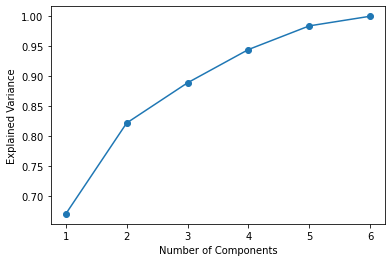

In [27]:
plt.plot(range(1,7), (pca.explained_variance_.cumsum())/(pca.explained_variance_.cumsum()[-1]), marker = "o")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

Just about 90% of the variance in the dataset is explained by the first three components, so we shall stick with the first three components.

In [29]:
pca_2= PCA(n_components = 3).fit(scaled)
transformed = pca_2.transform(scaled)

## Elbow Method & Clustering

The elbow method allows us to choose an optimal number of clusters with respect to the sum of the squared distances between the points and the cluster centers. Since we have more features than possible visible dimensions, this is a good alternative to determine the appropriate number of clusters without visualization.

In [19]:
distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(scaled)
    distortions.append(km.inertia_)

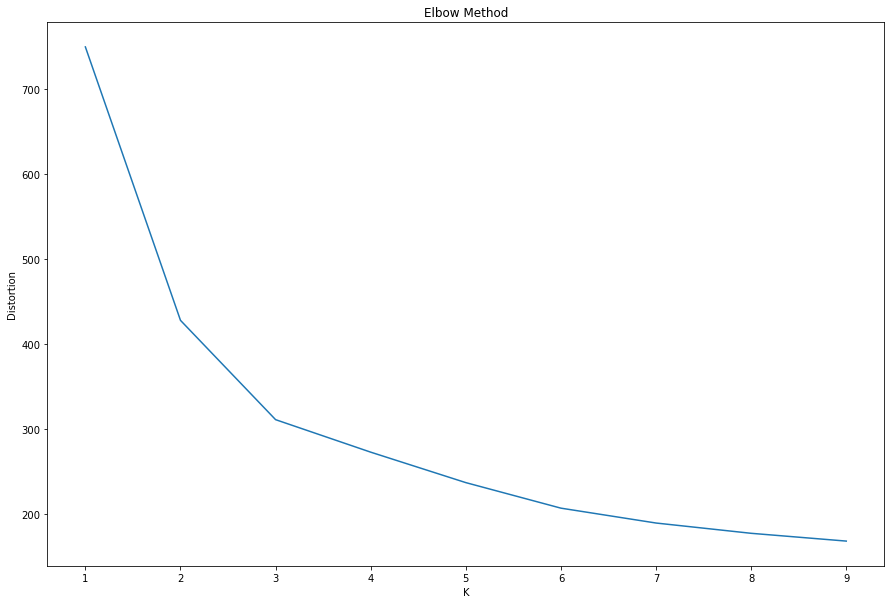

In [20]:
plt.figure(figsize=(15,10))
plt.plot(K, distortions)
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

The elbow method here shows that 3 clusters is the most appropriate in this case.

In [30]:
km = KMeans(n_clusters=3)
km.fit(transformed)
km.cluster_centers_

array([[-2.00600966, -0.38224038,  0.05228781],
       [ 2.88558536, -0.47432588,  0.15847355],
       [ 0.10114862,  0.55032336, -0.12380806]])

In [55]:
chicago_hs_clusters = chicago_hs.reset_index().join(pd.DataFrame(transformed))
chicago_hs_clusters.rename(columns={0: 'PC1', 1: 'PC2', 2: "PC3"}, inplace=True)
chicago_hs_clusters["Cluster"] = km.labels_
chicago_hs_clusters

,index,School ID,School Name,Dropout Avg,Grad Avg,Avg Attendance,% Students Earning Any ECCC,Enrollment Pct,Persistence Pct,PC1,PC2,PC3,Cluster
0,0,400121,ACERO - DE LA CRUZ,16.45,53.87,95.138095,31.30,55.950000,73.70,-0.071911,0.538810,-0.322321,2
1,1,400085,ACERO - GARCIA HS,9.45,56.83,92.806667,38.35,67.200000,72.55,-0.810843,0.338720,-0.324791,2
2,2,400149,ACERO - SOTO HS,11.20,51.23,88.480000,9.80,71.100000,82.60,-0.128175,1.562301,0.768008,2
3,3,610513,AIR FORCE HS,9.00,55.10,91.000000,83.87,61.433333,71.15,-0.814104,-1.729099,0.042295,0
4,4,610524,ALCOTT HS,9.50,59.03,89.913333,18.47,74.466667,71.65,-0.711271,1.180173,-0.325697,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,124,610392,WORLD LANGUAGE HS,6.35,57.77,90.766667,64.73,71.700000,69.80,-1.182021,-0.766340,-0.175555,0
121,125,609755,YOUNG HS,1.10,64.87,95.419048,86.80,87.300000,94.15,-3.762452,-1.070658,0.608054,0
122,126,610506,TEAM HS,27.40,44.70,68.170000,19.60,48.400000,46.80,4.484741,-0.243996,0.735269,1
123,127,400102,URBAN PREP - WEST HS,21.30,55.93,92.413333,4.23,62.900000,50.30,1.053337,1.558418,-1.333723,2


## Breaking Down the Clusters

Now that we have our clusters, let's break it down and interpret the results. First let's look at what each component represents in terms of our variables.

<AxesSubplot:xlabel='Component'>

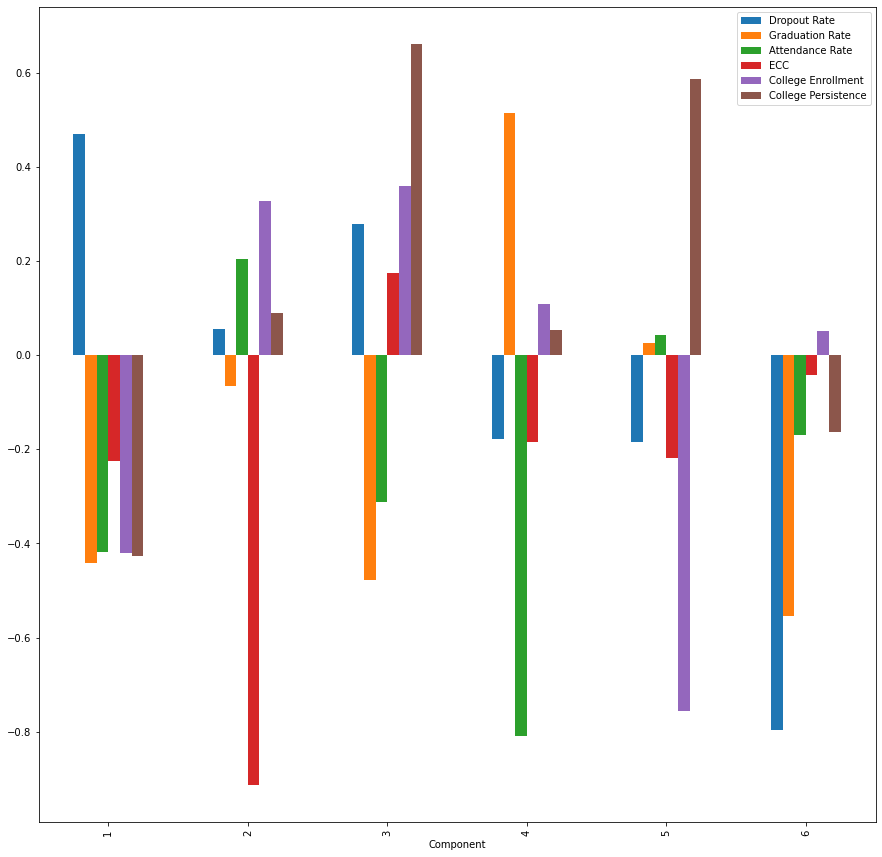

In [100]:
components = pd.DataFrame(pca.components_)
components.rename(columns={0: 'Dropout Rate', 1: 'Graduation Rate', 2: "Attendance Rate", 3: "ECC",4: "College Enrollment", 5: "College Persistence"}, inplace=True)
components["Component"] = components.index + 1
components.plot(x = "Component", y=['Dropout Rate', 'Graduation Rate', "Attendance Rate", "ECC", "College Enrollment", "College Persistence"], kind="bar", figsize =(15,15))

- The first component represents a positive weight in the dropout rate, and fairly negative weights on the rest of the categories, probably indicating lower performance schools. High dropout rates are not a good sign for school evaulation as well as negative performance in the rest of the categories.
- The second component represents more of a mixed bag with a heavy negative emphasis in College Credit earned throughout high school. This is probably representative of schools that focus on basic education with less access to more advanced courses.
- The third component emphasizes high college persistence rates, and low graduation rates which is an interesting combination of characteristics. This would mean that students who graduate from these schools tend to continue their studies in college, but there is a gap in the level of education of their student body or other circumstance that prevents a large portion from graduating.

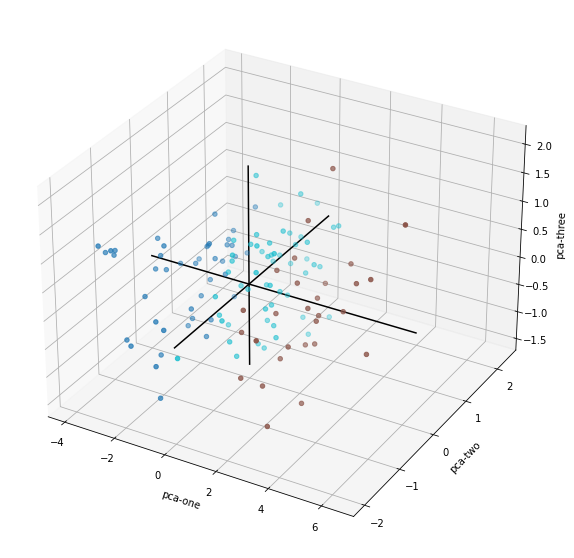

In [73]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=chicago_hs_clusters["PC1"], 
    ys=chicago_hs_clusters["PC2"], 
    zs=chicago_hs_clusters["PC3"], 
    c=chicago_hs_clusters["Cluster"], 
    cmap='tab10'
)
xAxisLine = ((min(chicago_hs_clusters['PC1']), max(chicago_hs_clusters['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'black')
yAxisLine = ((0, 0), (min(chicago_hs_clusters['PC2']), max(chicago_hs_clusters['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'black')
zAxisLine = ((0, 0), (0,0), (min(chicago_hs_clusters['PC3']), max(chicago_hs_clusters['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'black')

ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

For the most part, it seems that the clusters are segmented based on the first principal component. And after understanding our components, we see that a lower score on PCA 1 indicates a higher performing school, which means the dark blue is the top performing cluster, followed by the light blue, and then the brown. Now I will sort them into their respective clusters.

In [101]:
cluster_1 = []
cluster_2 = []
cluster_3 = []
for i in range(len(km.labels_)):
    if km.labels_[i] == 0:
        cluster_1.append(chicago_hs["School Name"].iloc[i])
    elif km.labels_[i] == 1:
        cluster_3.append(chicago_hs["School Name"].iloc[i])    
    else:
        cluster_2.append(chicago_hs["School Name"].iloc[i])

In [102]:
cluster_1

['AIR FORCE HS',
 'BACK OF THE YARDS HS',
 'BROOKS HS',
 'CARVER MILITARY HS',
 'CHIARTS HS',
 'CHICAGO ACADEMY HS',
 'CHICAGO AGRICULTURE HS',
 'CHICAGO MATH & SCIENCE HS',
 'CHICAGO MILITARY HS',
 'CICS - NORTHTOWN HS',
 'GOODE HS',
 'HANCOCK HS',
 'INFINITY HS',
 'INSTITUTO - HEALTH',
 'INTRINSIC HS',
 'JONES HS',
 'KENWOOD HS',
 'KING HS',
 'LANE TECH HS',
 'LINCOLN PARK HS',
 'LINDBLOM HS',
 'NOBLE - BULLS HS',
 'NOBLE - GOLDER HS',
 'NOBLE - MUCHIN HS',
 'NOBLE - NOBLE HS',
 'NOBLE - PRITZKER HS',
 'NOBLE - RAUNER HS',
 'NOBLE - UIC HS',
 'NORTHSIDE PREP HS',
 'OGDEN HS',
 'PAYTON HS',
 'PERSPECTIVES - JOSLIN HS',
 'PHOENIX MILITARY HS',
 'PROSSER HS',
 'RICKOVER MILITARY HS',
 'SIMEON HS',
 'SOLORIO HS',
 'SOUTH SHORE INTL HS',
 'TAFT HS',
 'VON STEUBEN HS',
 'WESTINGHOUSE HS',
 'WORLD LANGUAGE HS',
 'YOUNG HS']

In [103]:
cluster_2

['ACERO - DE LA CRUZ',
 'ACERO - GARCIA HS',
 'ACERO - SOTO HS',
 'ALCOTT HS',
 'AMUNDSEN HS',
 'ASPIRA - EARLY COLLEGE HS',
 'BOGAN HS',
 'BRONZEVILLE HS',
 'CATALYST - MARIA',
 'CHICAGO TECH HS',
 'CICS - CHICAGOQUEST HS',
 'CICS - ELLISON HS',
 'CICS - LONGWOOD',
 'CLARK HS',
 'CRANE MEDICAL HS',
 'CURIE HS',
 'DISNEY II HS',
 'EPIC HS',
 'HUBBARD HS',
 'JUAREZ HS',
 'KELLY HS',
 'KENNEDY HS',
 'LAKE VIEW HS',
 'MARINE LEADERSHIP AT AMES HS',
 'MATHER HS',
 'MORGAN PARK HS',
 'MULTICULTURAL HS',
 'NOBLE - BAKER HS',
 'NOBLE - BUTLER HS',
 'NOBLE - COMER',
 'NOBLE - DRW HS',
 'NOBLE - HANSBERRY HS',
 'NOBLE - JOHNSON HS',
 'NOBLE - ROWE CLARK HS',
 'NORTH LAWNDALE - CHRISTIANA HS',
 'NORTH LAWNDALE - COLLINS HS',
 'NORTH-GRAND HS',
 'PERSPECTIVES - LEADERSHIP HS',
 'PERSPECTIVES - MATH & SCI HS',
 'PERSPECTIVES - TECH HS',
 'ROOSEVELT HS',
 'SENN HS',
 'SOCIAL JUSTICE HS',
 'SPRY HS',
 'STEINMETZ HS',
 'U OF C - WOODLAWN HS',
 'UPLIFT HS',
 'URBAN PREP - BRONZEVILLE HS',
 'URBAN PREP

In [104]:
cluster_3

['AUSTIN CCA HS',
 'BOWEN HS',
 'CHICAGO VIRTUAL',
 'CHICAGO VOCATIONAL HS',
 'CLEMENTE HS',
 'COLLINS HS',
 'CORLISS HS',
 'DUNBAR HS',
 'FARRAGUT HS',
 'FOREMAN HS',
 'HARLAN HS',
 'HARPER HS',
 'HIRSCH HS',
 'HOPE HS',
 'HYDE PARK HS',
 'JULIAN HS',
 'KELVYN PARK HS',
 'LEGAL PREP HS',
 'MANLEY HS',
 'MARSHALL HS',
 'ORR HS',
 'PHILLIPS HS',
 'RABY HS',
 'RICHARDS HS',
 'SCHURZ HS',
 'SULLIVAN HS',
 'TILDEN HS',
 'TEAM HS']

In [105]:
chicago_hs[chicago_hs['School Name'].isin(cluster_1)].mean()

School ID                      546543.697674
Dropout Avg                         5.612791
Grad Avg                           60.718140
Avg Attendance                     92.413571
% Students Earning Any ECCC        61.651395
Enrollment Pct                     79.142636
Persistence Pct                    78.123256
dtype: float64

In [106]:
chicago_hs[chicago_hs['School Name'].isin(cluster_2)].mean()

School ID                      505035.907407
Dropout Avg                        14.412037
Grad Avg                           54.244074
Avg Attendance                     89.720370
% Students Earning Any ECCC        31.218889
Enrollment Pct                     68.306790
Persistence Pct                    66.372222
dtype: float64

In [107]:
chicago_hs[chicago_hs['School Name'].isin(cluster_3)].mean()

School ID                      594898.178571
Dropout Avg                        26.901786
Grad Avg                           46.200357
Avg Attendance                     81.844263
% Students Earning Any ECCC        39.365357
Enrollment Pct                     49.689286
Persistence Pct                    50.741071
dtype: float64

Now the top performing schools are in cluster 1 and the lower performing schools are in cluster 3.

In [108]:
def charter(cluster, attendance):
    school_type = {"Charter": 0, "Non-Charter":0}
    for school in cluster:
        if all(attendance.loc[attendance['School Name'] == school]["Network"].isin(["Charter"])):
            school_type["Charter"] += 1
        else:
            school_type["Non-Charter"] += 1
    return school_type
        

In [109]:
charter(cluster_1, raw_attendance)

{'Charter': 12, 'Non-Charter': 31}

In [110]:
charter(cluster_2, raw_attendance)

{'Charter': 26, 'Non-Charter': 28}

In [111]:
charter(cluster_3, raw_attendance)

{'Charter': 2, 'Non-Charter': 26}

Just out of my curiosity, we found that charter schools typically fall into into the top two clusters while the non-charter schools experience a more even distribution across the three groups.

## Geo-code Locations

First we have to find the addresses of the local high schools within Chicago and convert them into coordinates in order to map them.

In [115]:
import requests

api_key = ""
addresses = {}

for school in list(chicago_hs["School Name"]):
    search_term = ""
    search = school.split(" ")
    for word in search:
        search_term = search_term + word
        if word != search[-1]:
            search_term += "%20"
    url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=" + search_term + "&inputtype=textquery&fields=formatted_address&key=" + api_key
    response = requests.get(url).json()
    addresses[school] = response["candidates"][0]["formatted_address"]

In [116]:
address_coords = pd.Series(addresses).to_frame("Address")

In [117]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
address_coords['location'] = address_coords['Address'].apply(geocode)
address_coords['latitude'] = address_coords["location"].apply(lambda x: x.point[0] if x else None)
address_coords['longitude'] = address_coords["location"].apply(lambda x: x.point[1] if x else None)

In [118]:
address_coords = address_coords.dropna()
cluster_1.remove("NOBLE - MUCHIN HS")
cluster_3.remove("RICHARDS HS")

In [119]:
def mercator(df, lat="latitude", lon = "longitude"):
    k = 6378137
    df["x_coord"] = df[lon] * (k * np.pi/180.0)
    df["y_coord"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    
    return df

In [120]:
mercator(address_coords)

,Address,location,latitude,longitude,x_coord,y_coord
ACERO - DE LA CRUZ,"7416 N Ridge Blvd, Chicago, IL 60645, United S...","(7416-7430, North Ridge Boulevard, West Ridge,...",42.016547,-87.684980,-9.761047e+06,5.163458e+06
ACERO - GARCIA HS,"4248 W 47th St, Chicago, IL 60632, United States","(4248, West 47th Street, Archer Heights, Chica...",41.809092,-87.730789,-9.766147e+06,5.132425e+06
ACERO - SOTO HS,"5025 S St Louis Ave, Chicago, IL 60632, United...","(South Saint Louis Avenue, Brighton Park, Chic...",41.809193,-87.711042,-9.763948e+06,5.132440e+06
AIR FORCE HS,"3630 S Wells St, Chicago, IL 60609, United States","(3630, South Wells Street, Armour Square, Chic...",41.827880,-87.632958,-9.755256e+06,5.135231e+06
ALCOTT HS,"2957 N Hoyne Ave, Chicago, IL 60618, United St...","(Alcott College Prep, 2957, North Hoyne Avenue...",41.935504,-87.680382,-9.760535e+06,5.151323e+06
...,...,...,...,...,...,...
WORLD LANGUAGE HS,"3120 S Kostner Ave, Chicago, IL 60623, United ...","(Little Village Lawndale High School, 3120, So...",41.834567,-87.735292,-9.766648e+06,5.136230e+06
YOUNG HS,"211 S Laflin St, Chicago, IL 60607, United States","(Whitney M. Young Magnet High School, 211, Sou...",41.878192,-87.663108,-9.758613e+06,5.142751e+06
TEAM HS,"6201 S Stewart Ave, Chicago, IL 60621, United ...","(Team Englewood Community Academy, 6201, South...",41.782071,-87.634275,-9.755403e+06,5.128390e+06
URBAN PREP - WEST HS,"1326 W 14th Pl, Chicago, IL 60608, United States","(1326, West 14th Place, Near West Side, Univer...",41.862753,-87.660327,-9.758303e+06,5.140443e+06


In [121]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

tile_provider = get_provider(CARTODBPOSITRON)

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-9780000, -9745000), y_range=(5110000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

p.circle(x=address_coords.loc[cluster_1]["x_coord"], y=address_coords.loc[cluster_1]["y_coord"], size=10, fill_color="blue", fill_alpha=0.6)
p.circle(x=address_coords.loc[cluster_2]["x_coord"], y=address_coords.loc[cluster_2]["y_coord"], size=10, fill_color="red", fill_alpha=0.6)
p.circle(x=address_coords.loc[cluster_3]["x_coord"], y=address_coords.loc[cluster_3]["y_coord"], size=10, fill_color="green", fill_alpha=0.6)

output_notebook()
show(p)

Loading BokehJS ...

Looking at the visual breakdown, it doesn't seem that there is a significant pattern of performance in relation to the location of the schools. However, let's look at the division of neighborhoods as Chicago is a very stratified city.

In [124]:
import geopandas
gdf = geopandas.GeoDataFrame(address_coords, geometry=geopandas.points_from_xy(address_coords.longitude, address_coords.latitude))

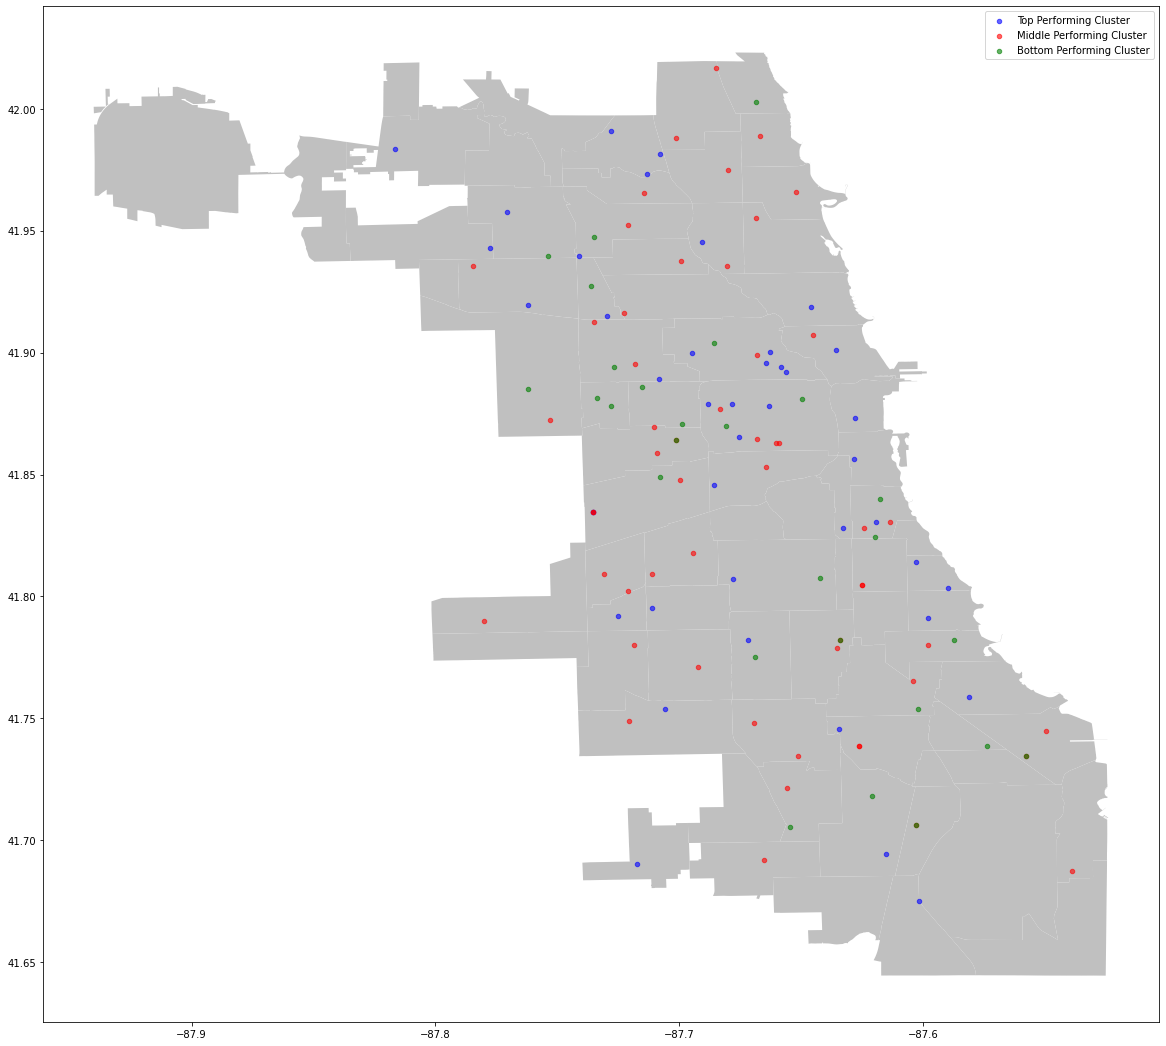

In [125]:
import geopandas
import descartes

neighborhoods = geopandas.read_file("/Users/nathanlee/Downloads/Boundaries - Community Areas (current)/geo_export_c50bf0f9-7241-4a84-a4ac-562d764a2e85.shp")

fig,ax = plt.subplots(figsize = (20,20))
neighborhoods.plot(ax = ax, color = "silver")


gdf.loc[cluster_1].plot(ax = ax, markersize = 20, color = "blue", alpha = 0.6, label = "Top Performing Cluster")
gdf.loc[cluster_2].plot(ax = ax, markersize = 20, color = "red", alpha = 0.6, label = "Middle Performing Cluster")
gdf.loc[cluster_3].plot(ax = ax, markersize = 20, color = "green", alpha = 0.6, label = "Bottom Performing Cluster")
plt.legend()

Looking at an overlay of the neighborhoods, it seems that there are better performing regions like North Chicago which is home to some of the wealthiest neighborhoods like Forest Glen and Lincoln Park. Plenty of the schools in the third cluster exist in West Chicago which is where many lowest income neighborhoods exist. The pattern of performance in these clusters seems very closely related to wealth (to no surprise) as the lowest income neighborhoods seem to have the lowest performing schools (according to the map of Chicago in 2017 below from a study conducted by the [Voorhees Center from the University of Illinois at Chicago](https://voorheescenter.wordpress.com/2018/06/06/who-can-live-in-chicago-part-i/)) The red indicates the lowest income neighborhoods while teh blue indicates the wealthiest.

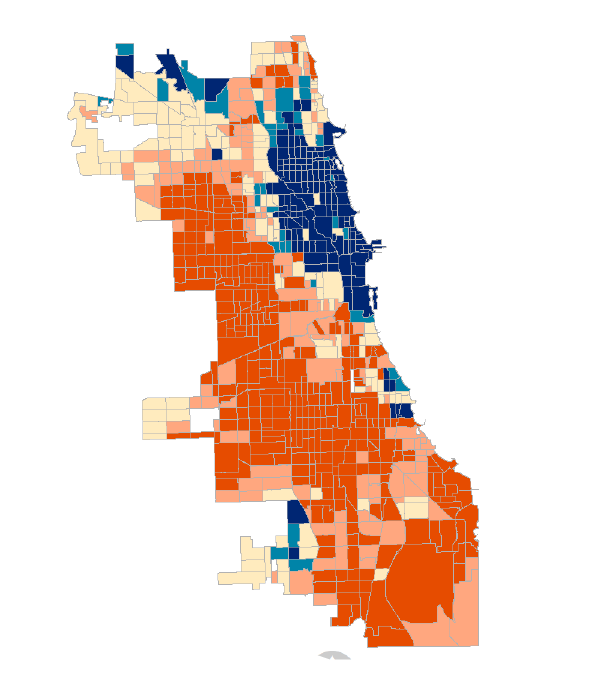